<a href="https://colab.research.google.com/github/adesam146/nlpcw/blob/rest_of_tasks/NLP_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Check GPU memory

In [0]:
#Check GPU Memory allocation
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [0]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.9 GB  | Proc size: 143.9 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
#run this if GPU utilization is not 0%
# !kill -9 -1

## Imports

In [0]:
!pip install -U spacy ftfy torchtext
!python -m spacy download en

Requirement already up-to-date: spacy in c:\projects\nlpcw\myvenv\lib\site-packages (2.0.18)
Requirement already up-to-date: ftfy in c:\projects\nlpcw\myvenv\lib\site-packages (5.5.1)

    Linking successful
    C:\projects\nlpcw\myvenv\lib\site-packages\en_core_web_sm -->
    C:\projects\nlpcw\myvenv\lib\site-packages\spacy\data\en

    You can now load the model via spacy.load('en')



You do not have sufficient privilege to perform this operation.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import sampler
import spacy
import torchvision.datasets as dset
from torchtext import data
from torchtext import datasets as nlp_dset
import random
from sklearn.utils import resample
import numpy as np
import pandas as pd

import torchvision.transforms as T

nlp_spaCy = spacy.load('en')

GPU = True
device_idx = 0
if GPU and torch.cuda.is_available():
    device = torch.device("cuda:"+str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

#Fix all seeds
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed(SEED)


cuda:0


In [3]:
# Load datafiles from own google drive
from google.colab import drive
drive.mount('/content/drive')
train_fp = """/content/drive/My Drive/colab_data/offenseval-training-v1.tsv"""

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## ELMO

In [0]:
!pip install torchvision torch allennlp
from allennlp.modules.elmo import Elmo, batch_to_ids

In [0]:
#Use pretrained ELMO weights. 
options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

elmo = Elmo(options_file, weight_file, 2, dropout=0)

100%|██████████| 374434792/374434792 [00:21<00:00, 17177971.67B/s]


In [0]:
#Elmo test
sentences = [['First', 'sentence', '.'], ['Another', '.'], 
             ["Oh", "here", "we", "Go", "now", "you", "fool", "."], 
             ["meaninglesswordnotinvocab"]]
             
character_ids = batch_to_ids(sentences)

embeddings = elmo(character_ids)

print(character_ids.shape)
embed = embeddings["elmo_representations"]
print(len(embed))
print(embed[0].shape)
print(embed[1].shape)


torch.Size([4, 8, 50])
2
torch.Size([4, 8, 1024])
torch.Size([4, 8, 1024])


In [0]:
# ELMO takes a list of parsed sentences as an input
# It generates an embedding of length 1024 per word
# We then need to find a good method of combining the word vecs to create 
# a sentence embedding (this article is good: https://medium.com/huggingface/universal-word-sentence-embeddings-ce48ddc8fc3a). 


## Import and preprocess Data

In [0]:
#ONLY RUN THIS CELL IF YOU WANT TO DOWNSAMPLE DATA - everything should work w/o this cell

#Select a subset of the data so that the classes are equally balanced
#Use downsampling for now. 

num_NOT = 8840
num_OFF = 4400
# Separate majority and minority classes
df_majority = train_df[train_df["subtask_a"] == 'NOT']
df_minority = train_df[train_df["subtask_a"] == 'OFF']

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=num_OFF,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
print(df_downsampled.subtask_a.value_counts())

df_downsampled = df_downsampled.sample(frac=1) #shuffle df


train_df = df_downsampled

NameError: ignored

In [0]:
def tweet_preprocess(tweet_text):
  """Add tweet specific preprocessing steps here"""
  
  #Remove 'USER' (but leave '@')
  tweet_text = tweet_text.replace("@USER", "@") 
  
  return tweet_text

def convert_labels_A(labels):
    """Preproceses and return labels"""

    final_labels = []
    for label in labels:
        assert label == "OFF" or label == "NOT", "Label should not be: {}".format(label)
    
        if label == "OFF":
            res = 1
        elif label == "NOT":
            res = 0        
        label = torch.tensor([res])
        final_labels.append(label)
    return final_labels
 

## GloVe

In [4]:
# Use two GloVe trained on two different corpuses for comparison:
    # Glove.6B
    # glove.twitter.27B
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

--2019-02-24 17:33:18--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2019-02-24 17:33:18--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  17.6MB/s    in 88s     

2019-02-24 17:34:47 (16.5 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [0]:
def tokenizer(text): # create a tokenizer function for gloVe
    res = [tok.text for tok in nlp_spaCy.tokenizer(text)]
    return res


In [11]:
#Create fields
BATCH_SIZE = 128


TEXT = data.Field(sequential=True, tokenize=tokenizer, lower=True, batch_first = True)
LABEL = data.LabelField(sequential=False, use_vocab=True, batch_first = True)
ID = data.LabelField(sequential=False, use_vocab=False, batch_first=True)

data_fields = [('id', ID), 
               ('tweet', TEXT),
               ('subtask_a',LABEL),
               ('subtask_b',LABEL),
               ('subtask_c',LABEL)]


train = data.TabularDataset(train_fp, format='TSV', fields = 
                            data_fields, skip_header=True)

train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f'Train size: {len(train)}')
print(f'Validation size: {len(valid)}')

#Now build vocab (using only the training set)
TEXT.build_vocab(train, vectors='glove.twitter.27B.200d') #USE "glove.840B.300d" or glove.twitter.27B.200d

LABEL.build_vocab(train.subtask_a)

output_dim = len(LABEL.vocab)

#Create iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                        batch_sizes=(BATCH_SIZE, len(valid)),  
                        sort_key=lambda x: len(x.tweet), device=device)

Train size: 10592
Validation size: 2648


In [12]:
print('first tweet', train[0].tweet)
print('first label', train[0].subtask_a)
print("first tweet id:", train[0].id)
# print(TEXT.vocab.stoi) # word to index
# print(LABEL.vocab.stoi) # word to index


first tweet ['@user', 'really', 'another', 'one', 'holy', 'crap', 'wow', 'all', 'brought', 'to', 'you', 'by', 'the', 'liberals', '.']
first label OFF
first tweet id: 49396


In [14]:
#check loader
for idx, batch in enumerate(train_iterator):
    inputs, labels = batch.tweet, batch.subtask_a
    print(inputs.shape)
    print(labels.shape)
    print(len(train_iterator))
    break


torch.Size([128, 72])
torch.Size([128])
67


In [0]:
from sklearn import metrics 

PRINT_EVERY = 50

def check_accuracy(loader, model, conf=False):
    """
    Note at the moment this function assumes the batch size is equal to the 
    number of data in the loader when calculating the confusion matrix
    """
    num_correct = 0
    num_samples = 0
    TP, TN, FP, FN = 0, 0, 0, 0
    
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            x, y = batch.tweet, batch.subtask_a
            y = y.view(-1, 1)
                
            x = x.to(device=device, dtype=torch.long)  # move to  GPU
            y = y.to(device=device, dtype=torch.long)
            pred_prob = torch.sigmoid(model(x))
            pred_1 = (pred_prob > 0.5).type(torch.long)
            num_correct += (pred_1 == y).sum()
            num_samples += pred_prob.size(0)
            
            # move to CPU to prevent memory overflow and calculate metrics
            x = x.to(device="cpu", dtype=torch.long)
            y = y.to(device="cpu", dtype=torch.long).numpy()
            pred_1 = pred_1.to(device="cpu", dtype=torch.long).numpy()
            
            if conf:
                TP, FP, FN, TN = metrics.confusion_matrix(y, pred_1).ravel()
            
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        if conf:
            print("TP = {}, FN = {}, TN = {}, FN = {}".format(TP, FP, TN, FN))
            print(metrics.classification_report(y, pred_1))
            
def check_loss(loader, model, loss_fn):
  model.eval()
  with torch.no_grad():
    loss = 0
    for idx, batch in enumerate(loader):
      x, y = batch.tweet, batch.subtask_a
      y = y.view(-1, 1)
      
      x = x.to(device=device, dtype=torch.long) 
      y = y.to(device=device, dtype=torch.long)
      
      output = model(x)
      
      y = y.type(torch.float)
      loss += loss_fn(output, y).item()
      
    return loss/len(loader)
      

def train_helper(model, optimizer, epochs=1, loss_fn = F.binary_cross_entropy_with_logits, 
               print_every=PRINT_EVERY, train_loader=train_iterator, 
               valid_loader=valid_iterator):
    """
    Train a model
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to GPU
    
    training_losses = []
    validation_losses = []
    try:
        for epoch in range(epochs):
            print("Epoch:", epoch)
            total_loss = 0
            for batch_idx, batch in enumerate(train_loader):

                model.train()  # put model to training mode
                
                #Eventually make this more generic so it works for all parts (a, b, c):
                inputs, targets = batch.tweet, batch.subtask_a
                
                x = inputs.to(device=device, dtype=torch.long)  # move to device, e.g. GPU
                y = targets.to(device=device, dtype=torch.float) #this should be a float cross entropy
                #x = inputs
                #y = targets
                logits = model(x)
                y = y.type(torch.float)
                loss = loss_fn(logits.view((-1,)), y)
                # Zero out all of the gradients for the variables which the optimizer
                # will update.
                optimizer.zero_grad()

                # This is the backwards pass: compute the gradient of the loss with
                # respect to each  parameter of the model.
                loss.backward()

                # Actually update the parameters of the model using the gradients
                # computed by the backwards pass.
                optimizer.step()

                x = x.to(device="cpu", dtype=torch.long)  # move to CPU to prevent memory overflow
                y = y.to(device="cpu", dtype=torch.long)

                total_loss += loss.detach().item()
                
                if batch_idx % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (batch_idx, loss.item()))
            
            training_losses.append(total_loss/len(train_iterator))
            print()
            print("Validation Accuracy:")
            check_accuracy(valid_loader, model, conf=True)
            valid_loss = check_loss(valid_loader, model, loss_fn)
            validation_losses.append(valid_loss)
            print()
        return training_losses, validation_losses
    except Exception as e:
        #Attempt to prevent GPU memory overflow by transferring model back to cpu
        #model = model.to(device="cpu")
        raise e    

In [0]:
#embedding (lookup layer) layer
class SimpleClassifierGloVe(nn.Module):
    """Glove w. 2d conv"""
    
    def __init__(self, vocab, embedding_dim, window_size, out_channels, dropout):
        
        super(SimpleClassifierGloVe, self).__init__()
        
        
        self.vocab = vocab
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.embedding.weight.data.copy_(vocab.vectors) # copies pre-trained word vectors

        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size, embedding_dim))

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(out_channels, 1)

        #Kaming normalization
        nn.init.kaiming_normal_(self.conv.weight)
        nn.init.kaiming_normal_(self.fc.weight)

        
        
    def forward(self, x):
        
        embedded = self.embedding(x)
                
        #(batch size, max sent length, embedding dim)
        
        #images have 3 RGB channels 
        #for the text we add 1 channel
        embedded = embedded.unsqueeze(1)
        
        #(batch size, 1, max sent length, embedding dim)
        
        feature_maps =  F.relu(self.conv(embedded).squeeze(3))
        # (batch size, out_channels, max sent length - window size +1, 1)
        # -> (batch size, out_channels, max sent length - window size +1)
           
        #the max pooling layer
        pooled = F.max_pool1d(feature_maps, feature_maps.shape[2]).squeeze(2)
        # (batch size, out_channels)      
        
        # Do batch normalize pooled then at sentiment
        
        return self.fc( self.dropout(pooled))


In [43]:
#CONV with Glove
embedding_dim = 200
window_size = 3
lr = 0.00025
out_channels = 100
dropout = 0.5

model = SimpleClassifierGloVe(TEXT.vocab, embedding_dim, window_size, out_channels, dropout)

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()


t_losses, v_losses = train_helper(model, optimizer, loss_fn = loss_fn, epochs = 20)


Epoch: 0
Iteration 0, loss = 1.0039
Iteration 50, loss = 0.7888

Validation Accuracy:
Got 1412 / 2118 correct (66.67)
TP = 1377, FN = 18, TN = 35, FN = 688
              precision    recall  f1-score   support

           0       0.67      0.99      0.80      1395
           1       0.66      0.05      0.09       723

   micro avg       0.67      0.67      0.67      2118
   macro avg       0.66      0.52      0.44      2118
weighted avg       0.66      0.67      0.56      2118


Epoch: 1
Iteration 0, loss = 0.8521
Iteration 50, loss = 0.8099

Validation Accuracy:
Got 1448 / 2118 correct (68.37)
TP = 1368, FN = 27, TN = 80, FN = 643
              precision    recall  f1-score   support

           0       0.68      0.98      0.80      1395
           1       0.75      0.11      0.19       723

   micro avg       0.68      0.68      0.68      2118
   macro avg       0.71      0.55      0.50      2118
weighted avg       0.70      0.68      0.59      2118


Epoch: 2
Iteration 0, loss = 0.6

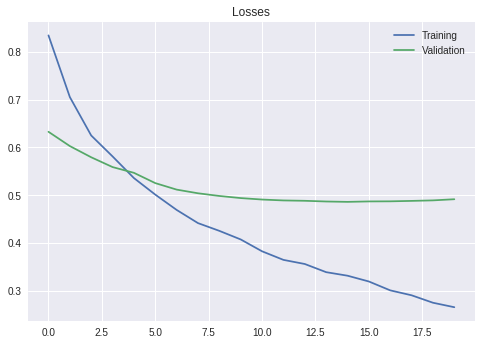

In [44]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(t_losses, label='Training')
ax1.plot(v_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

plt.show()

## Bert Pre-processing

In [0]:
# BERT summary
# The first token of every sequence is the classification embedding "[CLS]"
# There are two types of sentence in the representation: A & B. These are used for
# Question-answering systems. For our purposes, all sentences/tweets will be type A. 
# A and B are seperated with the special token "[SEP]". Again, we don't need this here.

# We should use the "bert-large-uncased" eventually which has 1024 latent features
# but for now use "bert-base-uncased" which has 768


#The model returns the embedded representations in the form:
# encoded_layers, pooled_output
# encoded_layers: The activations of each of the 12 layers (or 24 layers in BERT-large)
#                 list of length 12/24 where each element is a tensor of dimensions:
#                 (B, L, F) for Batch size B, sequence length L and number feautures F

#if you want the output embeddings per word, use encoded_layers[-1]
#if you want to use the BERT sentence embedding use pooled_output
# We will use pooled_output for now

#encoded_layers, pooled_output = model(tokens_tensor, segments_tensor)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased')
def convert_tweets_to_features(tweet_list, seq_length, tokenizer):
    """returns the BERT features"""

    tokenized_tweets = []
    input_ids_list = []
    input_masks = []
    input_type_ids_list= []
                
    for (index, tweet) in enumerate(tweet_list):
       
        
        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0      0   0    1  1  1   1  1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        
        tweet = tweet_preprocess(tweet)
        tokens_a = tokenizer.tokenize(tweet)
            
        tokens = []
        input_type_ids = []
        tokens.append("[CLS]")
        input_type_ids.append(0)
        for token in tokens_a:
            tokens.append(token)
            input_type_ids.append(0)
        tokens.append("[SEP]")
        input_type_ids.append(0)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)
        #print("current length input ids:", len(input_ids))
        
        # Zero-pad up to the sequence length.
        while len(input_ids) < seq_length:
            input_ids.append(0)
            input_mask.append(0)
            input_type_ids.append(0)

        assert len(input_ids) == seq_length, "{} should = {}".format(len(input_ids), seq_length)
        assert len(input_mask) == seq_length
        assert len(input_type_ids) == seq_length
        
        input_ids_tensor = torch.tensor(input_ids)
        input_mask_tensor = torch.tensor(input_mask)
        input_type_ids_tensor = torch.tensor(input_type_ids)
    
        tokenized_tweets.append(tokens)
        input_ids_list.append(input_ids_tensor)
        input_masks.append(input_mask_tensor)
        input_type_ids_list.append(input_type_ids_tensor)
        
    results = (tokenized_tweets, input_ids_list, input_masks, input_type_ids_list)
    return results


In [0]:
#Preprocessing BERT

tweet_train_list = train_df["tweet"].tolist()
tweet_valid_list = valid_df["tweet"].tolist()
#find max length of tokens 
max_len = 0
longest_tokens = None
for tweet in (tweet_train_list + tweet_valid_list):
    tweet = tweet_preprocess(tweet)
    tokens = tokenizer.tokenize(tweet)
    tokens_len = len(tokens)
    if tokens_len > max_len:
        max_len = tokens_len
        longest_tokens = tokens 
        
print("Max token length is", max_len)

#Add an extra few symbols in case the tweets in the test-set are longer
MAX_SEQ = max_len + 4 

#preprocess tweets and extract labels
LABELS_TRAIN = convert_labels_A(train_df["subtask_a"].tolist())
FEATURES_TRAIN = convert_tweets_to_features(tweet_train_list, MAX_SEQ, tokenizer)

LABELS_VALID = convert_labels_A(valid_df["subtask_a"].tolist())
FEATURES_VALID = convert_tweets_to_features(tweet_valid_list, MAX_SEQ, tokenizer)

Max token length is 119


In [0]:
#BERT Data Loaders 
BATCH_SIZE = 32

def train_loader(batch_size = BATCH_SIZE, labels = LABELS_TRAIN, features = FEATURES_TRAIN):
    """Training Loader"""
    return loader_gen(batch_size = BATCH_SIZE, labels = LABELS_TRAIN, features = FEATURES_TRAIN)
def valid_loader():
    """Validate set loader"""
    return loader_gen(batch_size = BATCH_SIZE, labels = LABELS_VALID, features = FEATURES_VALID)
    
def loader_gen(batch_size = BATCH_SIZE, labels = LABELS_TRAIN, features = FEATURES_TRAIN):
    """Generator - bespoke loader. 
    yields an output of (data, label).
        data is a torch tensor of shape (B, L, 2)
            where B is batch size, L is number of tokens per tweet and the final 
            dimension holds the BERT token indexes and the BERT token masks 
            in the first and second components respectively"""
    
    (tokenized_tweets, tweet_ids_list, input_masks, input_type_ids_list) = features 
    
    batch_id_tensor_list = []
    batch_mask_tensor_list = []
    batch_labels_tensor_list = []
    for (idx, tweet_ids) in enumerate(tweet_ids_list):

        batch_id_tensor_list.append(tweet_ids)
        batch_mask_tensor_list.append(input_masks[idx])
        batch_labels_tensor_list.append(labels[idx])
        
        if len(batch_id_tensor_list) == BATCH_SIZE:
            
            #Then produce and yield an output batch tensor and label
            batch_id_tensor = torch.stack(batch_id_tensor_list)
            batch_mask_tensor = torch.stack(batch_mask_tensor_list)
            input_tensor = torch.stack((batch_id_tensor, batch_mask_tensor), dim=2)
            batch_labels_tensor = torch.stack(batch_labels_tensor_list)
            
            assert batch_mask_tensor.shape == (batch_size, MAX_SEQ)
            assert batch_id_tensor.shape == (batch_size, MAX_SEQ)
            assert input_tensor.shape == (batch_size, MAX_SEQ, 2)
            assert batch_labels_tensor.shape == (batch_size, 1)
            
            
            yield (input_tensor, batch_labels_tensor)
            batch_id_tensor_list = []
            batch_mask_tensor_list = []
            batch_labels_tensor_list = []
    
    #check if there is a small batch left...
    if len(batch_id_tensor_list) > 0:
        batch_id_tensor = torch.stack(batch_id_tensor_list)
        batch_mask_tensor = torch.stack(batch_mask_tensor_list)
        input_tensor = torch.stack((batch_id_tensor, batch_mask_tensor), dim=2)
        batch_labels_tensor = torch.stack(batch_labels_tensor_list)
        
        yield (input_tensor, batch_labels_tensor)
    
    

In [0]:
PRINT_EVERY = 50

def check_accuracy(loader, model, conf=False): 
    num_correct = 0
    num_samples = 0
    TP, TN, FP, FN = 0, 0, 0, 0
    
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for idx, (x, y) in enumerate(loader()):
            x = x.to(device=device, dtype=torch.long)  # move to  GPU
            y = y.to(device=device, dtype=torch.long)
            pred_prob = model(x)
            pred_1 = (pred_prob > 0.5).type(torch.long)
            num_correct += (pred_1 == y).sum()
            num_samples += pred_prob.size(0)
            
            if conf:
                #find confusion matrix
                
                #find number correct class 1
                TP += ((pred_1 == 1) & (y == 1)).sum()
                FP += ((pred_1 == 1) & (y == 0)).sum()
                TN += ((pred_1 == 0) & (y == 0)).sum()
                FN += ((pred_1 == 0) & (y == 1)).sum()
            
            x = x.to(device="cpu", dtype=torch.long)  # move to CPU to prevent memory overflow
            y = y.to(device="cpu", dtype=torch.long)
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        if conf:
            print("TP = {}, FN = {}, TN = {}, FN = {}".format(TP, FP, TN, FN))

def train_part(model, optimizer, epochs=1, loss_fn = F.binary_cross_entropy, print_every=PRINT_EVERY):
    """
    Train a model
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to GPU
    try:
        for e in range(epochs):
            for batch_idx, (inputs, targets) in enumerate(train_loader()):

                model.train()  # put model to training mode

                x = inputs.to(device=device, dtype=torch.long)  # move to device, e.g. GPU
                y = targets.to(device=device, dtype=torch.float) #this should be a float cross entropy
                #x = inputs
                #y = targets
                prob = model(x)
                y = y.type(torch.float)
                loss = loss_fn(prob, y)
                # Zero out all of the gradients for the variables which the optimizer
                # will update.
                optimizer.zero_grad()

                # This is the backwards pass: compute the gradient of the loss with
                # respect to each  parameter of the model.
                loss.backward()

                # Actually update the parameters of the model using the gradients
                # computed by the backwards pass.
                optimizer.step()

                x = x.to(device="cpu", dtype=torch.long)  # move to CPU to prevent memory overflow
                y = y.to(device="cpu", dtype=torch.long)

                if batch_idx % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (batch_idx, loss.item()))
                    check_accuracy(valid_loader, model, conf=True)
            print()
            print("Validation Accuracy:")
            check_accuracy(valid_loader, model, conf=True)
            print()

    except Exception as e:
        #Attempt to prevent GPU memory overflow by transferring model back to cpu
        #model = model.to(device="cpu")
        raise e

### Test BERT Loader

In [0]:
#Test loader
#get first batch from train loader
#Now compare with values obtained w/o loader
(_, tweet_ids_list, input_masks, _) = FEATURES_TRAIN

tweet_ids_tensor = tweet_ids_list[0].view((1, -1)) #use just first value
input_masks = input_masks[0].view((1, -1))
with torch.no_grad():
    bert.eval()
    encoded_2, pooled_output_2 = bert(tweet_ids_tensor, output_all_encoded_layers=False,
                                               attention_mask=input_masks, )
    
for idx, (inputs, targets) in enumerate(train_loader()):

    input_ids = inputs[:, :, 0] #token IDs
    attention_mask = inputs[:, :, 1]  #attention mask (to ignore padding)
    with torch.no_grad():
        bert.eval()
        encoded_layers, pooled_output = bert(input_ids, output_all_encoded_layers=False,
                                                       attention_mask=attention_mask, )
    assert False #to stop full loop

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [0]:
assert torch.allclose(attention_mask, input_masks)
assert torch.allclose(input_ids, tweet_ids_tensor)

with torch.no_grad():
    bert.eval()
    encoded_3, pooled_output_3 = bert(tweet_ids_tensor, output_all_encoded_layers=False,
                                                   attention_mask=input_masks, )
    encoded_4, pooled_output_4 = bert(tweet_ids_tensor, output_all_encoded_layers=False,
                                                   attention_mask=input_masks, )


assert torch.allclose(pooled_output_3, pooled_output_4) 
print(pooled_output_3[0, 3])
print(pooled_output_4[0, 3])

## BERT Models

In [0]:
class FcnnBertEmbeddingBinary(nn.Module):
    "Bert with fully connected NN"
    def __init__(self, embedding_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, max_len):
        
        super(FcnnBertEmbeddingBinary, self).__init__()
        
        #embedding (lookup layer) layer
        self.embedding = BertModel.from_pretrained('bert-base-uncased')
        
        #hidden layers
        self.fc1 = nn.Linear(embedding_dim, hidden_dim_1, bias=True)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2, bias = True) 
        self.fc3 = nn.Linear(hidden_dim_2, hidden_dim_3, bias = True)
        
        #output layer
        self.fc4 = nn.Linear(hidden_dim_3, 1, bias = True)
        
        #Kaming normalization
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)
        nn.init.kaiming_normal_(self.fc4.weight)
        
    def forward(self, x):
        
        #Put into .eval mode to export exact weights
        self.eval()
        input_ids = x[:, :, 0] #token IDs
        attention_mask = x[:, :, 1]  #attention mask (to ignore padding)
        
        
        encoded_layers, pooled_output = self.embedding(input_ids, 
                                                     attention_mask=attention_mask)
        self.train()
        
        #Use 'pooled output' as the overall embedding of the sentence.
        #This is recommended in the BERT paper for classification tasks
        
        #A bit of background on what we are doing here:
        #BERT creates its vectors by taking context before and context 
        #after every token in the sequence. The pooled_output is the 
        #resultant vector for the first token and is (according to the paper)
        #the best representation of the sentence as a whole
        h = F.relu(pooled_output)
        h = F.relu(self.fc1(h))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = torch.sigmoid(self.fc4(h))
        
        return h

class SimpleClassifierWBert(nn.Module):
    """Bert w. 2d conv"""
    def __init__(self, out_channels, window_size, dropout):
        super(SimpleClassifierWBert, self).__init__()
        
        self.embedding = BertModel.from_pretrained('bert-base-uncased')
        embedding_dim = 768
        
        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size, embedding_dim))
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(out_channels, 1)
        
        #Kaming normalization
        nn.init.kaiming_normal_(self.conv.weight)
        nn.init.kaiming_normal_(self.fc.weight)

        
        
    def forward(self, x):
        self.eval()
        input_ids = x[:, :, 0] #token IDs
        attention_mask = x[:, :, 1]  #attention mask (to ignore padding)
        
        encoded_layers, pooled_output = self.embedding(input_ids, output_all_encoded_layers=False,
                                                       attention_mask=attention_mask )
        self.train()
        
        #Use 'final encoded layer' which is of size:
            #[batch_size, sequence_length, embedding_dim]
        
        embedded = encoded_layers.unsqueeze(1)
        
        assert embedded.shape == (BATCH_SIZE, 1, MAX_SEQ, 768)
        
        #(batch size, 1, max sent length, embedding dim)
        
        feature_maps =  F.relu(self.conv(embedded).squeeze(3))
        # (batch size, out_channels, max sent length - window size +1, 1)
        # -> (batch size, out_channels, max sent length - window size +1)
           
        #the max pooling layer
        pooled = F.max_pool1d(feature_maps, feature_maps.shape[2]).squeeze(2)
        # (batch size, out_channels)      
 
        return self.fc( self.dropout(pooled))


In [0]:
#CONV with bert
embedding_dim = 768
max_len = MAX_SEQ
hidden_dim_1 = 128
hidden_dim_2 = 16
hidden_dim_3 = 4
lr = 0.00025

model = SimpleClassifierWBert(out_channels=100, window_size=3, dropout=0.5)

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss()


train_part(model, optimizer, loss_fn = loss_fn, epochs = 5)


In [0]:
#Fully connected w. Bert sentence embeddings
embedding_dim = 768
max_len = MAX_SEQ
hidden_dim_1 = 128
hidden_dim_2 = 16
hidden_dim_3 = 4
lr = 0.00025

model = FcnnBertEmbeddingBinary(embedding_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, max_len)

optimizer = optim.Adam(model.parameters(), lr)

train_part(model, optimizer, epochs = 5)

Iteration 0, loss = 0.7172
Got 77 / 320 correct (24.06)
TP = 77, FN = 243, TN = 0, FN = 0
Iteration 50, loss = 0.7054
Got 243 / 320 correct (75.94)
TP = 0, FN = 0, TN = 243, FN = 77
Iteration 100, loss = 0.7053
Got 243 / 320 correct (75.94)
TP = 0, FN = 0, TN = 243, FN = 77
Iteration 150, loss = 0.7087
Got 77 / 320 correct (24.06)
TP = 77, FN = 243, TN = 0, FN = 0
Iteration 200, loss = 0.6910
Got 243 / 320 correct (75.94)
TP = 0, FN = 0, TN = 243, FN = 77
Iteration 250, loss = 0.6941
Got 243 / 320 correct (75.94)
TP = 0, FN = 0, TN = 243, FN = 77

Validation Accuracy:
Got 243 / 320 correct (75.94)
TP = 0, FN = 0, TN = 243, FN = 77

Iteration 0, loss = 0.6938
Got 77 / 320 correct (24.06)
TP = 77, FN = 243, TN = 0, FN = 0
Iteration 50, loss = 0.6933
Got 243 / 320 correct (75.94)
TP = 0, FN = 0, TN = 243, FN = 77
Iteration 100, loss = 0.6940
Got 243 / 320 correct (75.94)
TP = 0, FN = 0, TN = 243, FN = 77
Iteration 150, loss = 0.6926
Got 243 / 320 correct (75.94)
TP = 0, FN = 0, TN = 243, 

KeyboardInterrupt: ignored

## Samuel's code (for conv architecture)

In [0]:
#Samuel's code
class SimpleClassifierELMO(nn.Module):
    def __init__(self, out_channels, window_size, dropout):
        super(SimpleClassifierELMO, self).__init__()
        self.embeddings = Elmo(options_file, weight_file, 1, dropout=0)
        embedding_dim = 1024
        
        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size, embedding_dim))
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(out_channels, 1)
        
    def forward(self, x):
        # x is the output from batch_to_ids
        
        
        # Only looking at one (the first) layer from elmo for now 
        # which is my I am indexing at 0
        #images have 3 RGB channels 
        #for the text we add 1 channel
        embedded = self.embeddings(x.type(torch.long))['elmo_representations'][0].unsqueeze(1)
        
        #(batch size, 1, max sent length, embedding dim)
        
        feature_maps =  F.relu(self.conv(embedded).squeeze(3))
        # (batch size, out_channels, max sent length - window size +1, 1)
        # -> (batch size, out_channels, max sent length - window size +1)
           
        #the max pooling layer
        pooled = F.max_pool1d(feature_maps, feature_maps.shape[2]).squeeze(2)
        # (batch size, out_channels)      
 
        return self.fc( self.dropout(pooled))

def accuracy(output, target):
    with torch.no_grad():
        prob_output = torch.sigmoid(output)

        prob_output[prob_output > 0.5] = 1.
        prob_output[prob_output <= 0.5] = 0.

        acc = (prob_output == target).sum(dtype=torch.float) / output.shape[0]
 
    return acc
def f_measure(output, gold):
  
  with torch.no_grad():
    prob_output = torch.sigmoid(output)

    prob_output[prob_output > 0.5] = 1.
    prob_output[prob_output <= 0.5] = 0.

    TP = FN = FP = TN = 0

    for i in range(gold.shape[0]):
      if gold[i] == prob_output[i]:
        if gold[i] == 1:
          TP += 1.
        else:
          TN += 1.
      else:
        if gold[i] == 1:
          FN += 1.
        else:
          FP += 1.
          
    print("TP, FN, FP, TN", TP, FN, FP, FP)

    recall = TP/(TP + FN) if FN else 0
    precision = TP/(TP + FP) if FP else 0
    fscore = 2 * precision * recall /(precision + recall) if precision and recall else 0
  
  print("Recall: %.2f, Precision: %.2f, F-measure: %.2f" % (recall, precision, fscore))

In [0]:
#Samuel's preprocessing
import re

def get_tokenised_corpus(corpus):
    """
    This assumes the corpus can be iterated through and
    retains the order in which the sentences appeared in the corpus
    """
    tokenized_corpus = [] # Let us put the tokenized corpus in a list
    for sentence in corpus:
        tokenized_sentence = []
        for token in re.split(r'\s', sentence.lower()): # simplest split is 
            if token:
              # To avoid the empty string
              tokenized_sentence.append(token)
        tokenized_corpus.append(tokenized_sentence)
    
    return tokenized_corpus

train = train_df 

total = train['id'].count().item()
off_count = train[train['subtask_a'] == "OFF"]['id'].count()


training_percent = 0.8
training_size = int(training_percent * total)
validation_size = total - training_size

corpus = train['tweet'].values
labels = train['subtask_a']
labels[labels == 'OFF'] = 1
labels[labels == 'NOT'] = 0

labels = labels.values
labels = labels.astype(np.float).reshape(-1, 1)

indices = list(range(total))
np.random.shuffle(indices)
training_sents = corpus[indices[:training_size]]
training_labels = labels[indices[:training_size]]

validation_sents = corpus[indices[training_size:]]
validation_labels = labels[indices[training_size:]]

training_ids = batch_to_ids(get_tokenised_corpus(training_sents))
validation_ids = batch_to_ids(get_tokenised_corpus(validation_sents))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [0]:
BATCH_SIZE = 32
dtype = torch.long
data_loader = DataLoader(TensorDataset(training_ids, torch.from_numpy(training_labels)), batch_size=BATCH_SIZE, shuffle=True)
model = SimpleClassifierELMO(out_channels=100, window_size=3, dropout=0.5)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)

validation_ids = torch.as_tensor(validation_ids).to(device, dtype=dtype)
validation_labels = torch.as_tensor(validation_labels).to(device, dtype=torch.float)

NUM_EPOCHS = 1
training_losses = []
training_accs = []
validation_losses = []
validation_accs = []

for epoch in range(NUM_EPOCHS):
  epoch_loss = 0
  epoch_acc = 0
  
  print("Epoch", epoch)
  
  for sent_ids, target in data_loader:
    model.train()
    optimizer.zero_grad()

    sent_ids = sent_ids.to(device, dtype=dtype)
    target = target.to(device, dtype=torch.float)

    logits = model(sent_ids).type(torch.cuda.FloatTensor)

    loss = loss_fn(logits, target)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.detach().item()
    epoch_acc += accuracy(logits, target)
  
  epoch_loss = epoch_loss/BATCH_SIZE
  epoch_acc = epoch_acc/BATCH_SIZE

  model.eval()
  with torch.no_grad():
    logits = model(validation_ids)
    logits = logits.type(torch.cuda.FloatTensor)

    validation_loss = loss_fn(logits, validation_labels).item()
    validation_acc = accuracy(logits, validation_labels).item()
    
    print(f'| Epoch: {epoch:02} | Train. Loss: {epoch_loss:.3f} | Train. Acc: {epoch_acc*100:.2f}| Val. Loss: {validation_loss:.3f} | Val. Acc: {validation_acc*100:.2f}% \n')
    f_measure(logits, validation_labels)
    
  training_losses.append(epoch_loss)
  training_accs.append(epoch_acc)
  validation_losses.append(validation_loss)
  validation_accs.append(validation_acc)

## Misc

In [0]:
#Save intermediate results to CSV so we can use the nice torchtext .TabularDataset loader
train_df.to_csv(path_or_buf=PREPROCESSED_FP, sep=',', na_rep='', float_format=None, 
                header=True, index=True, )

#train = pd.read_csv("offenseval-training-v1.tsv", delimiter="\t")
#test = pd.read_csv("offenseval-trial (2).txt", delimiter="\t")
train = None

#define our batch size
BATCH_SIZE = 4

text_field = data.Field(sequential = False, use_vocab = False, dtype = torch.long)
label_field = data.LabelField(sequential= False, dtype=torch.float, use_vocab = False)


#text_field.build_vocab(train, max_size=25000, vectors="glove.6B.100d")
#label_field.build_vocab(train)

train = data.TabularDataset(PREPROCESSED_FP, 'CSV', fields = 
                            [('TWEET_IDS', text_field), ('LABEL_A', label_field)], 
                            skip_header=False)
#train = data.Dataset(examples=tweets_IDs, fields= [("tweet", text_field)])


train_iterator = data.Iterator(train, batch_size = BATCH_SIZE, )


In [0]:
#OLD BERT METHOD
#train = pd.read_csv("offenseval-training-v1.tsv", delimiter="\t")
#test = pd.read_csv("offenseval-trial (2).txt", delimiter="\t")
train = None
test = None

#define our batch size
BATCH_SIZE = 64

text_field = data.Field(tokenize=BERT_tokenize, preprocessing = BERT_retrieve_ID, use_vocab = True, dtype = torch.long)
label_field = data.LabelField(sequential= False, preprocessing = section_a_labels, dtype=torch.float, use_vocab = False)


#text_field.build_vocab(train, max_size=25000, vectors="glove.6B.100d")
#label_field.build_vocab(train)

train = data.TabularDataset("offenseval-training-v1.tsv", 'TSV', fields = 
                            { "tweet": ("tweet", text_field), "subtask_a": ("LabelA", label_field),}, skip_header=False)

text_field.build_vocab(train, vectors="glove.6B.50d") #USE "glove.840B.300d" or glove.twitter.27B.200d
label_field.build_vocab(train)

glove_dim = 50

#define our batch size
BATCH_SIZE = 64

#define types of data and their preprocessing

#get pre-defined split
#train = text_field.preprocess(train.iloc[0]["tweet"])
#print(train)

train_iterator = data.Iterator(train, batch_size = BATCH_SIZE, device="cuda")

  

NameError: ignored